### tests settings

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#let's set the parameters
M_bh = 10**6.3
nu0 = 3.3*10**(-5)

# Physical constants
G = 6.67430e-11       # m^3 kg^-1 s^-2
c = 299792458         # m/s
Msun = 1.98847e30     # kg

Rg_sun = G * Msun / c**2  # in m
#let's set the tolerance for the target frequency
tol = 0.01 * nu0  # 1% tolerance
target_min = 1e-5
target_max = 1e-4

In [16]:
# Kerr ISCO radius
def r_isco(a):
    if a==0:
        return 6
    Z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    return 3 + Z2 - abs(a)/a*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2))

### PIF

#### funzione base

confrontiamo la funzione già integrata con quela da integrare

In [17]:
# Kerr frequencies in Hz
# i compute Rg separating M because I'll may try some different value
def nu_phi(r, a, M=M_bh):
    # r in units of GM/c^2, a dimensionless (0–1), M in solar masses
    Rg = Rg_sun * M  # in cm
    return c / (Rg*(r**1.5 + abs(a)))

def nu_theta(r, a, M=M_bh):
    vphi = nu_phi(r, a, M)
    factor = np.sqrt(1 - (4*abs(a))/r**1.5 + (3*a**2)/r**2)
    return vphi * factor

def nu_r(r, a, M=M_bh):
    vphi = nu_phi(r, a, M)
    factor = np.sqrt(1 - (6)/r + (8*abs(a))/r**1.5 - (3*a**2)/r**2)
    return vphi * factor
# Kerr ISCO radius
def r_isco(a):
    if a==0:
        return 6
    Z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    return 3 + Z2 - abs(a)/a*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2))

# lense-thirring precession frequency
def nu_LT(r, a, M=M_bh):
    return nu_phi(r, a, M) - nu_theta(r, a, M)

#periastron precession frequency
def nu_per(r, a, M=M_bh):
    return nu_phi(r, a, M) - nu_r(r, a, M)

#### funzioni brutte

In [7]:
def nu_prec_solid_body(a, M, r_in, r_out, zeta=0.0):  
    _eps = 1e-14          # small tolerance

    # convert inputs to numpy arrays for safe broadcasting
    a_arr = np.asarray(a, dtype=float)
    r_in_arr = np.asarray(r_in, dtype=float)
    r_out_arr = np.asarray(r_out, dtype=float)
    zeta_arr = np.asarray(zeta, dtype=float)
    
    # mass in kg and gravitational radius Rg = G M / c^2
    Rg = Rg_sun*M
    
    # Prepare output array with broadcasting shape
    shape = np.broadcast(a_arr, r_in_arr, r_out_arr, zeta_arr).shape
    omega = np.full(shape, np.nan, dtype=float)
    
    # Quick guard: invalid radii
    invalid = (r_out_arr <= r_in_arr) | (r_in_arr <= 0)
    if np.any(invalid):
        # we'll leave those entries as NaN, but continue computing valid ones
        pass
    
    # compute common factors safely on broadcasted arrays
    # To avoid invalid broadcasting complexities, create full arrays via broadcast_to
    A = np.broadcast_to(a_arr, shape)
    RIN = np.broadcast_to(r_in_arr, shape)
    ROUT = np.broadcast_to(r_out_arr, shape)
    Z = np.broadcast_to(zeta_arr, shape)
    
    # Denominator checks
    denom_pref = 1.0 + 2.0 * Z
    denom_pref_bad = np.isclose(denom_pref, 0.0, atol=_eps)
    
    power1 = Z + 0.5
    power2 = 2.5 - Z  # 5/2 - zeta
    denom_power_term = 1.0 - (RIN / ROUT)**(power2)
    denom_power_bad = np.isclose(denom_power_term, 0.0, atol=_eps)
    
    # valid mask: rout > rin, denominators ok
    valid = (~invalid) & (~denom_pref_bad) & (~denom_power_bad)
    
    if not np.any(valid):
        omega / (2*np.pi)
    
    # compute safe quantities where valid
    # factor = (2 * a * c / Rg) * ((5 - 2 zeta) / (1 + 2 zeta))
    prefactor = (2.0 * A * c / Rg) * ((5.0 - 2.0 * Z) / denom_pref)
    
    # numerator: 1 - (r_in / r_out)^(zeta + 1/2)
    num = 1.0 - (RIN / ROUT)**(power1)
    
    # denominator: r_out^(5/2 - zeta) * r_in^(1/2 - zeta) * (1 - (r_in/r_out)^(5/2 - zeta))
    denom = (ROUT**(power2)) * (RIN**(0.5 - Z)) * denom_power_term
    
    # compute omega only for valid entries
    omega[valid] = prefactor[valid] * (num[valid] / denom[valid])
    
    # a == 0 => omega = 0 (ensured by prefactor). if tiny numerical noise appears, force exact zero:
    omega[np.isclose(A, 0.0, atol=_eps) & valid] = 0.0
    nu = omega / (2.0 * np.pi)

    return nu


/tmp/ipykernel_11406/2665212901.py:36: RuntimeWarning: invalid value encountered in power
  denom_power_term = 1.0 - (RIN / ROUT)**(power2)
/tmp/ipykernel_11406/2665212901.py:50: RuntimeWarning: invalid value encountered in power
  num = 1.0 - (RIN / ROUT)**(power1)
/tmp/ipykernel_11406/2665212901.py:53: RuntimeWarning: invalid value encountered in power
  denom = (ROUT**(power2)) * (RIN**(0.5 - Z)) * denom_power_term
/tmp/ipykernel_11406/2665212901.py:36: RuntimeWarning: divide by zero encountered in divide
  denom_power_term = 1.0 - (RIN / ROUT)**(power2)
/tmp/ipykernel_11406/2665212901.py:50: RuntimeWarning: divide by zero encountered in divide
  num = 1.0 - (RIN / ROUT)**(power1)
/tmp/ipykernel_11406/2665212901.py:53: RuntimeWarning: divide by zero encountered in power
  denom = (ROUT**(power2)) * (RIN**(0.5 - Z)) * denom_power_term
/tmp/ipykernel_11406/2665212901.py:53: RuntimeWarning: invalid value encountered in multiply
  denom = (ROUT**(power2)) * (RIN**(0.5 - Z)) * denom_powe

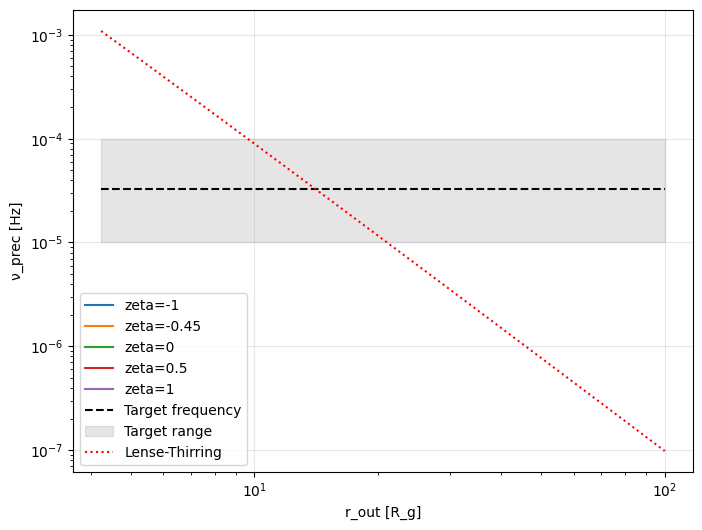

In [18]:
a = 0.5
rin = r_isco(a)
routs = np.linspace(rin, 1e2, 100)
zetas = [-1, -0.45, 0, 0.5, 1]

nu_solid = [nu_prec_solid_body(a, rin, routs, z, M_bh) for z in zetas]

plt.figure(figsize=(8,6))
for i, z in enumerate(zetas):
    plt.plot(routs, nu_solid[i], label=f"zeta={z}") 

plt.plot(routs, np.ones_like(routs)*nu0, label="Target frequency", color='black', linestyle='--')
plt.fill_between(routs, target_min, target_max, color='gray', alpha=0.2,
                label="Target range")

plt.plot(routs, nu_LT(routs, a), label="Lense-Thirring", color='red', linestyle=':')

plt.xlabel("r_out [R_g]")
plt.ylabel("ν_prec [Hz]")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()



c'è qualche problema con la frequenza di solid body perché 
* a rin con z=0.5 diventa simile a nu_lt, ma non uguale... e sta cosa succede solo per sto valore fortunato!
* a rin c'è una dipendenza da zeta che non dovrebbe esserci, le curve non si avvicinano abbastanza
* se cambio rin anche lo 0.5 si discosta

ok, con l'integrale funziona, il problema era che quella formula p validsa solo nel caso di campo debole, perciò vicino al BH no!

In [9]:
a_range = np.linspace(-0.999, 0.999, 10001)  # Spins
r_ins = np.array([np.exp(np.linspace(np.log(r_isco(a)), np.log(5e2), 400)) for a in a_range])
#r_outs = [np.exp(np.linspace(np.log(r_isco(a)), np.log(1e4), 800)) for a in a_range]

# broadcast zeta
zetas = np.array([-0.45, 0, 0.5])
ZETA = zetas[:, None, None, None]  # shape (Nz,1,1,1)

In [10]:
from scipy.optimize import root_scalar
def f_rout(r_out, a, M, r_in, zeta):
    return nu_prec_solid_body(a, M, r_in, r_out, zeta) - nu0

matches = []
for i, a in enumerate(a_range):
    for zeta in zetas:
        for r_in in r_ins[i]:
            # bracket for r_out (must be > r_in)
            rlow = r_in * 1.05
            rhigh = 1000

            try:
                sol = root_scalar(
                    f_rout, args=(a, M_bh, r_in, zeta),
                    bracket=[rlow, rhigh], method="brentq"
                )
                if sol.converged:
                    r_out = sol.root
                    freq = nu_prec_solid_body(a, M_bh, r_in, r_out, zeta)
                    matches.append((a, r_in, r_out, zeta, freq))
            except ValueError:
                pass

KeyboardInterrupt: 

In [ ]:
matches = []
for i, a in enumerate(a_range):
    for r_in in r_ins[i]:
        r_out_grid = np.exp(np.linspace(np.log(r_in*1.05), np.log(1e3), 800))
        
        for zeta in zetas:
            for r_out in r_out_grid:
                freq = nu_prec_solid_body(a, M_bh, r_in, r_out, zeta)
                if abs(freq - nu0) < tol:
                    matches.append((a, r_in, r_out, zeta, freq))

if matches.size > 0:
    print(f"\nFOUND MATCHES:")
    for m in matches:
        print(f"a={m[0]}, r_in={m[1]} R_g, r_out={m[2]} R_g, zeta={m[3]} → ν={m[4]} Hz")


In [20]:
def nu_prec_solid_body(a, rin, rout, zeta, M_bh):
    """
    Fully vectorized solid-body LT precession frequency.
    Works on arrays of any shape (broadcasting).
    Returns frequency in Hz.
    """

    # Exponents for angular momentum weighting
    p = 0.5 - zeta    # integrand exponent for denominator
    q = 1.5 - zeta    # integrand exponent for numerator

    # Analytic integrals (vectorized)
    I_den = (rout**(p+1) - rin**(p+1)) / (p+1)
    I_num = (rout**(q+1) - rin**(q+1)) / (q+1)

    # Dimensionless precession (geometric units)
    nu_geo = (a / np.pi) * (I_num / I_den)

    # Hz conversion: (c^3)/(G M) = 3.23e4 Hz per solar mass
    M_factor = 3.23e4 / M_bh

    return nu_geo * M_factor


a_range = np.linspace(-95, 95, 191)  # Spins
a_range = a_range/100
a_range = np.insert(a_range, 0, -0.998)  # add extreme retrograde spin
a_range = np.append(a_range, 0.998)      # add extreme prograde spin

r_in_list = []
for a in a_range:
    r0 = r_isco(a)
    rvals = np.exp(np.linspace(np.log(r0), np.log(1e2), 100))  #5e2, 200
    r_in_list.append(rvals)
# stack into (Na, Nr)
r_in_grid = np.array(r_in_list)

# build r_out grid for all spins & all r_in
r_out_list = []
for i, a in enumerate(a_range):
    row = []
    for rin in r_in_grid[i]:
        rvals = np.exp(np.linspace(np.log(rin*1.05), np.log(5e2), 500))
        row.append(rvals)
    r_out_list.append(row)
r_out_grid = np.array(r_out_list)  # shape (Na, Nr_in, Nr_out)

zetas = np.array([-0.45, 0, 0.5])

A     = a_range[:, None, None, None]             # (Na,1,1,1)
RIN   = r_in_grid[:, :, None, None]              # (Na,Nr,1,1)
ROUT  = r_out_grid[:, :, :, None]                # (Na,Nr,No,1)
ZETA  = zetas[None, None, None, :]               # (1,1,1,Nz)

freqs = nu_prec_solid_body(A, RIN, ROUT, ZETA, M_bh)  
# shape: (Na, Nr, No, Nz)

mask = np.abs(freqs - nu0) < tol       # boolean array (Na, Nr, No, Nz)

i, j, k, l = np.where(mask)

matches = list(zip(
    A[i,0,0,0],
    RIN[i,j,0,0],
    ROUT[i,j,k,0],
    ZETA[0,0,0,l],
    freqs[i,j,k,l]
))

for (a, rin, rout, z, freq) in matches:
    print(f"zeta={z: .2f}, a={a: .3f}, rin={rin: .3f}, rout={rout: .3f}, ν={freq: .3f} Hz")


/tmp/ipykernel_11406/2460325221.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = f"a={a_val}, r_in={float(rin_val):.4f}"


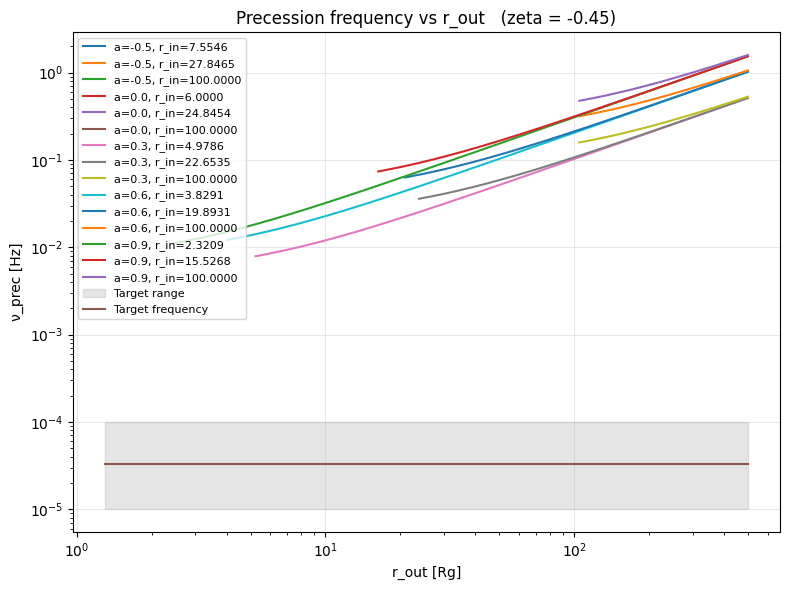

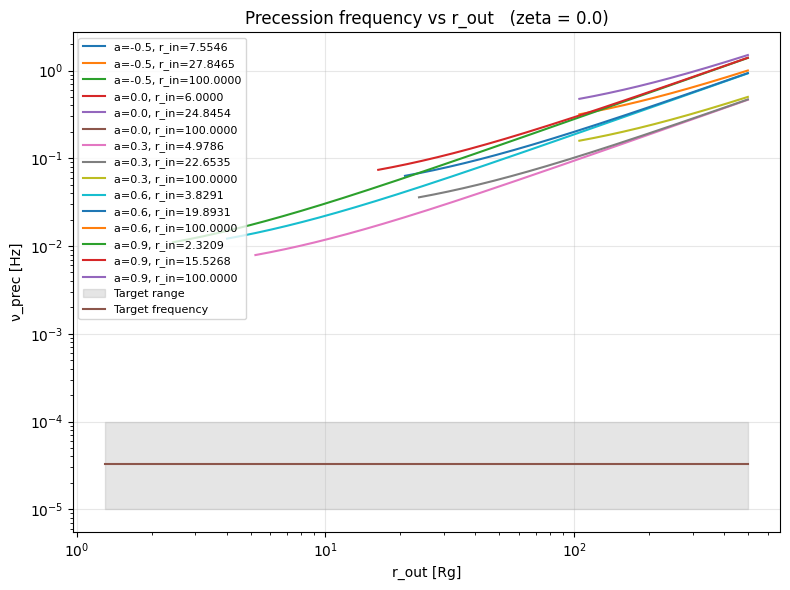

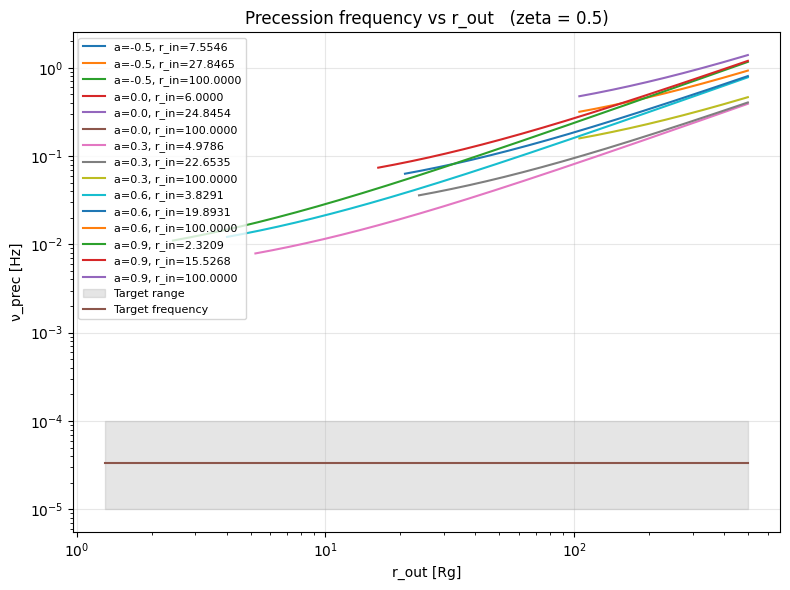

In [22]:
# Choose indices to plot
a_chosen = np.array([-0.5, 0, 0.3, 0.6, 0.9])         # example
rin_idxs  = [0, 50, 99]                    # example
colors = plt.cm.viridis(np.linspace(0, 1, len(a_chosen)))


# Loop over zeta values
for iz, zeta in enumerate(zetas):
    plt.figure(figsize=(8, 6))
    
    for a_val in a_chosen:
        ia = np.where(a_range == a_val)
        
        for ir in rin_idxs:
            rin_val  = RIN[ia, ir, 0, 0]        # scalar
            rout_vals = ROUT[ia, ir, :, 0]      # vector shape (No,)
            freq_vals = freqs[ia, ir, :, iz]    # vector shape (No,)
            
            # plot only valid positive frequencies
            mask2 = np.isfinite(freq_vals) & (freq_vals > 0)
            
            label = f"a={a_val}, r_in={float(rin_val):.4f}"
            plt.plot(rout_vals[mask2], freq_vals[mask2], label=label)

            
    
    # Target frequency band
    plt.fill_between(r_out_grid[-1, 0], target_min, target_max, color='gray', alpha=0.2,
                    label="Target range")
    plt.plot(r_out_grid[-1, 0], np.ones_like(rout_vals[mask2])*nu0, label="Target frequency")

    plt.title(f"Precession frequency vs r_out   (zeta = {zeta})")
    plt.xlabel("r_out [Rg]")
    plt.ylabel("ν_prec [Hz]")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
#  FUNCTIONS
# -----------------------------

# relativistic frequencies
def nu_phi(R, a):
    return 1.0 / (R**1.5 + a)

def nu_theta(R, a):
    return nu_phi(R, a) * np.sqrt(1 - 4*a/R**1.5 + 3*a**2/R**2)

def nu_LT(R, a):
    return nu_phi(R, a) - nu_theta(R, a)

# Kerr ISCO radius
def r_isco(a):
    if a==0:
        return 6
    Z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    return 3 + Z2 - abs(a)/a*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2))

# fast vectorized version
def nu_prec_vectorized(a, rin, rout, zeta, n_rad=200):
    """
    Vectorized relativistic solid-body precession frequency.
    All arrays must be broadcastable to a common shape.
    """

    # 1) create a shared radial grid x∈[0,1]
    x = np.linspace(0, 1, n_rad)
    x = x.reshape((1,)*a.ndim + (n_rad,))     # broadcasting axis at the end

    # 2) rebuild full R(a,rin,rout,x)
    R = rin[...,None] + x * (rout - rin)[...,None]

    # 3) relativistic quantities
    Sigma = R**(-zeta[...,None])
    weight = Sigma * R**3 * nu_phi(R, a[...,None])

    num = np.trapezoid(nu_LT(R, a[...,None]) * weight, x, axis=-1)
    den = np.trapezoid(weight, x, axis=-1)

    return num / den


# Numerical integral version (your "true" frequency)
def nu_prec_numeric(a, r_in, r_out, zeta, n_rad=500):
    R = np.linspace(r_in, r_out, n_rad)
    Sigma = R**(-zeta)
    weight = Sigma * R**3 * nu_phi(R, a)

    num = np.trapezoid(nu_LT(R, a) * weight, R)
    den = np.trapezoid(weight, R)

    return num / den  # geometric units


# -----------------------------
#  PARAMETERS
# -----------------------------

a     = 0.5      # spin
r_in  = 6.0      # fixed inner radius
zeta  = 0.0      # density slope
M_bh  = 10       # solar masses, used only if converting Hz (not needed here)

# Sweep outer radius
r_out_vals = np.linspace(1.05 * r_in, 200, 200)

# -----------------------------
#  COMPUTE BOTH FREQUENCIES
# -----------------------------

"""
a_range = np.linspace(-95, 95, 191)  # Spins
a_range = a_range/100
a_range = np.insert(a_range, 0, -0.998)  # add extreme retrograde spin
a_range = np.append(a_range, 0.998)      # add extreme prograde spin

r_in_list = []
for a in a_range:
    r0 = r_isco(a)
    rvals = np.exp(np.linspace(np.log(r0), np.log(75), 75))  #5e2, 200
    r_in_list.append(rvals)
# stack into (Na, Nr)
r_in_grid = np.array(r_in_list)

# build r_out grid for all spins & all r_in
r_out_list = []
for i, a in enumerate(a_range):
    row = []
    for rin in r_in_grid[i]:
        rvals = np.exp(np.linspace(np.log(rin*1.05), np.log(250), 250))
        row.append(rvals)
    r_out_list.append(row)
r_out_grid = np.array(r_out_list)  # shape (Na, Nr_in, Nr_out)

zetas = np.array([-0.45, 0, 0.5])

A     = a_range[:, None, None, None]      # (Na,1,1,1)
RIN   = r_in_grid[:, :, None, None]       # (Na,Nr,1,1)
ROUT  = r_out_grid[:, :, :, None]         # (Na,Nr,No,1)
ZETA  = zetas[None, None, None, :]        # (1,1,1,Nz)

nu_approx = nu_prec_vectorized(A, RIN, ROUT, ZETA)  # (Na,Nr,No,Nz)
"""


In [ ]:
nu_true   = np.array([nu_prec_numeric(a, r_in, ro, zeta) for ro in r_out_vals])

In [ ]:
nu_approx = np.array([nu_prec_numeric(a, r_in, ro, zeta) for ro in r_out_vals])
print(nu_approx.shape)

In [ ]:
# -----------------------------
#  PLOT
# -----------------------------

# Choose indices to plot
a_chosen = np.array([0.5])         # example
rin_idxs  = [0]                    # example
colors = plt.cm.viridis(np.linspace(0, 1, len(a_chosen)))


plt.plot(r_out_vals, nu_true,   label="Numerical (trapezoidal)", lw=2)
plt.plot(r_out_vals, nu_approx, label="Vectorized formula", ls="--", lw=2)

plt.title(f"Precession frequency vs r_out   (zeta = {zeta})")
plt.xlabel("r_out [Rg]")
plt.ylabel("ν_prec [Hz]")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
